# Naive time adaptive method

In [1]:
# importing library
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

### Defineing diffusivity profile

In [2]:
import sympy
#sympy.init_printing()

z = sympy.symbols('z')

K0 = 1e-6# m * * 2 / s
K1 = 6e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)


In [3]:
#######
#Euler#
#######
def step_e(z, fixed, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)

    a = dKdz(fixed)
    b = np.sqrt(2 * Diffu(fixed))

    temp = z + a * dt + b * dW
    return temp


def step_e_const(z, fixed, H, dt, N_sample):

    K0 = 3e-3
    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    temp = z + np.sqrt(2 * K0) * dW
    return temp

### Defining functions for time adaptive

In [4]:
def oneStep(upperBound, lowerBound, TimeAdaptive, scheme, n, H, dt):

    maskBody = ((upperBound < TimeAdaptive) & (lowerBound > TimeAdaptive))

    zBody = TimeAdaptive[maskBody]
    zBody = scheme(zBody, zBody, H, dt, zBody.size)
    
    zBody=np.where(zBody<0, -zBody ,zBody)
    zBody=np.where(zBody>H, 2*H-zBody,zBody)

    zEdge = TimeAdaptive[~maskBody]
    zFixed = zEdge.copy()
    
    for j in range(n):
        zEdge = scheme(zEdge, zFixed, H, dt / n, zEdge.size)
        zEdge=np.where(zEdge<0, -zEdge ,zEdge)
        zEdge=np.where(zEdge>H, 2*H-zEdge,zEdge)

    TimeAdaptive[maskBody] = zBody
    TimeAdaptive[~maskBody] = zEdge

    return TimeAdaptive

def parallelBodyEdge(Tmax, dt, H, prosent, n, Testdepth, Np, Nbins, quene,
                     scheme):
    np.random.seed()
    upperBound = H * prosent
    lowerBound = H - upperBound
    Ntime = int(Tmax / dt)

    hist = np.zeros((Nbins - 1, ), 'i')
    TimeAdaptive = np.random.uniform(0, H, int(Np))

    for i in range(Ntime):

        TimeAdaptive = oneStep(upperBound, lowerBound, TimeAdaptive, scheme, n,
                               H, dt)
        temp0, _ = np.histogram(TimeAdaptive,
                                bins=np.linspace(0, Testdepth, Nbins))
        hist = hist + temp0

        if (i % int(Ntime / 100) == 0):
            print("\r %6.2f" % (i * 100 / Ntime + 1),
                  "%",
                  end="\r",
                  flush=True)

    quene.put(hist)
    return None

def RunSimulation(NumberOfThread, Tmax, dt, H, prosent, n, Testdepth, Np,
                  Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)

    Ntime = int(Tmax / dt)  #Number of time interval

    if (__name__ == '__main__'):
        threads = []
        quene = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallelBodyEdge,
                                args=(Tmax, dt, H, prosent, n, Testdepth,
                                      SubNp[i], Nbins, quene, scheme))
            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist = np.zeros((Nbins - 1, ), 'i')

    for i in range(NumberOfThread):
        hist += quene.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist = (hist * H) / (Np * dz * (Ntime + 1))

    return hist

In [5]:
# Criterion checking

z=np.linspace(0, 10,1000)
profile=dAdz(z)
Maxdt=(1/np.max(np.abs(profile)))
print(Maxdt)

166.66666666666666


### E1

In [6]:
Np = 80000
Nbins = 600
Tmax = 4 * 3600  #Maximum time
dt = 1  #Delta time
H = 2
prosent = 0.1
n = 10
Testdepth = 0.5
NumberOfThread = 4

E1 = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, n, Testdepth, Np,
                   Nbins, step_e)
E1_Const = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, n, Testdepth,
                         Np, Nbins, step_e_const)
n = 1
E1_normal = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, n, Testdepth,
                          Np, Nbins, step_e)

Total number of process:  4
Total number of process:  4
Total number of process:  4


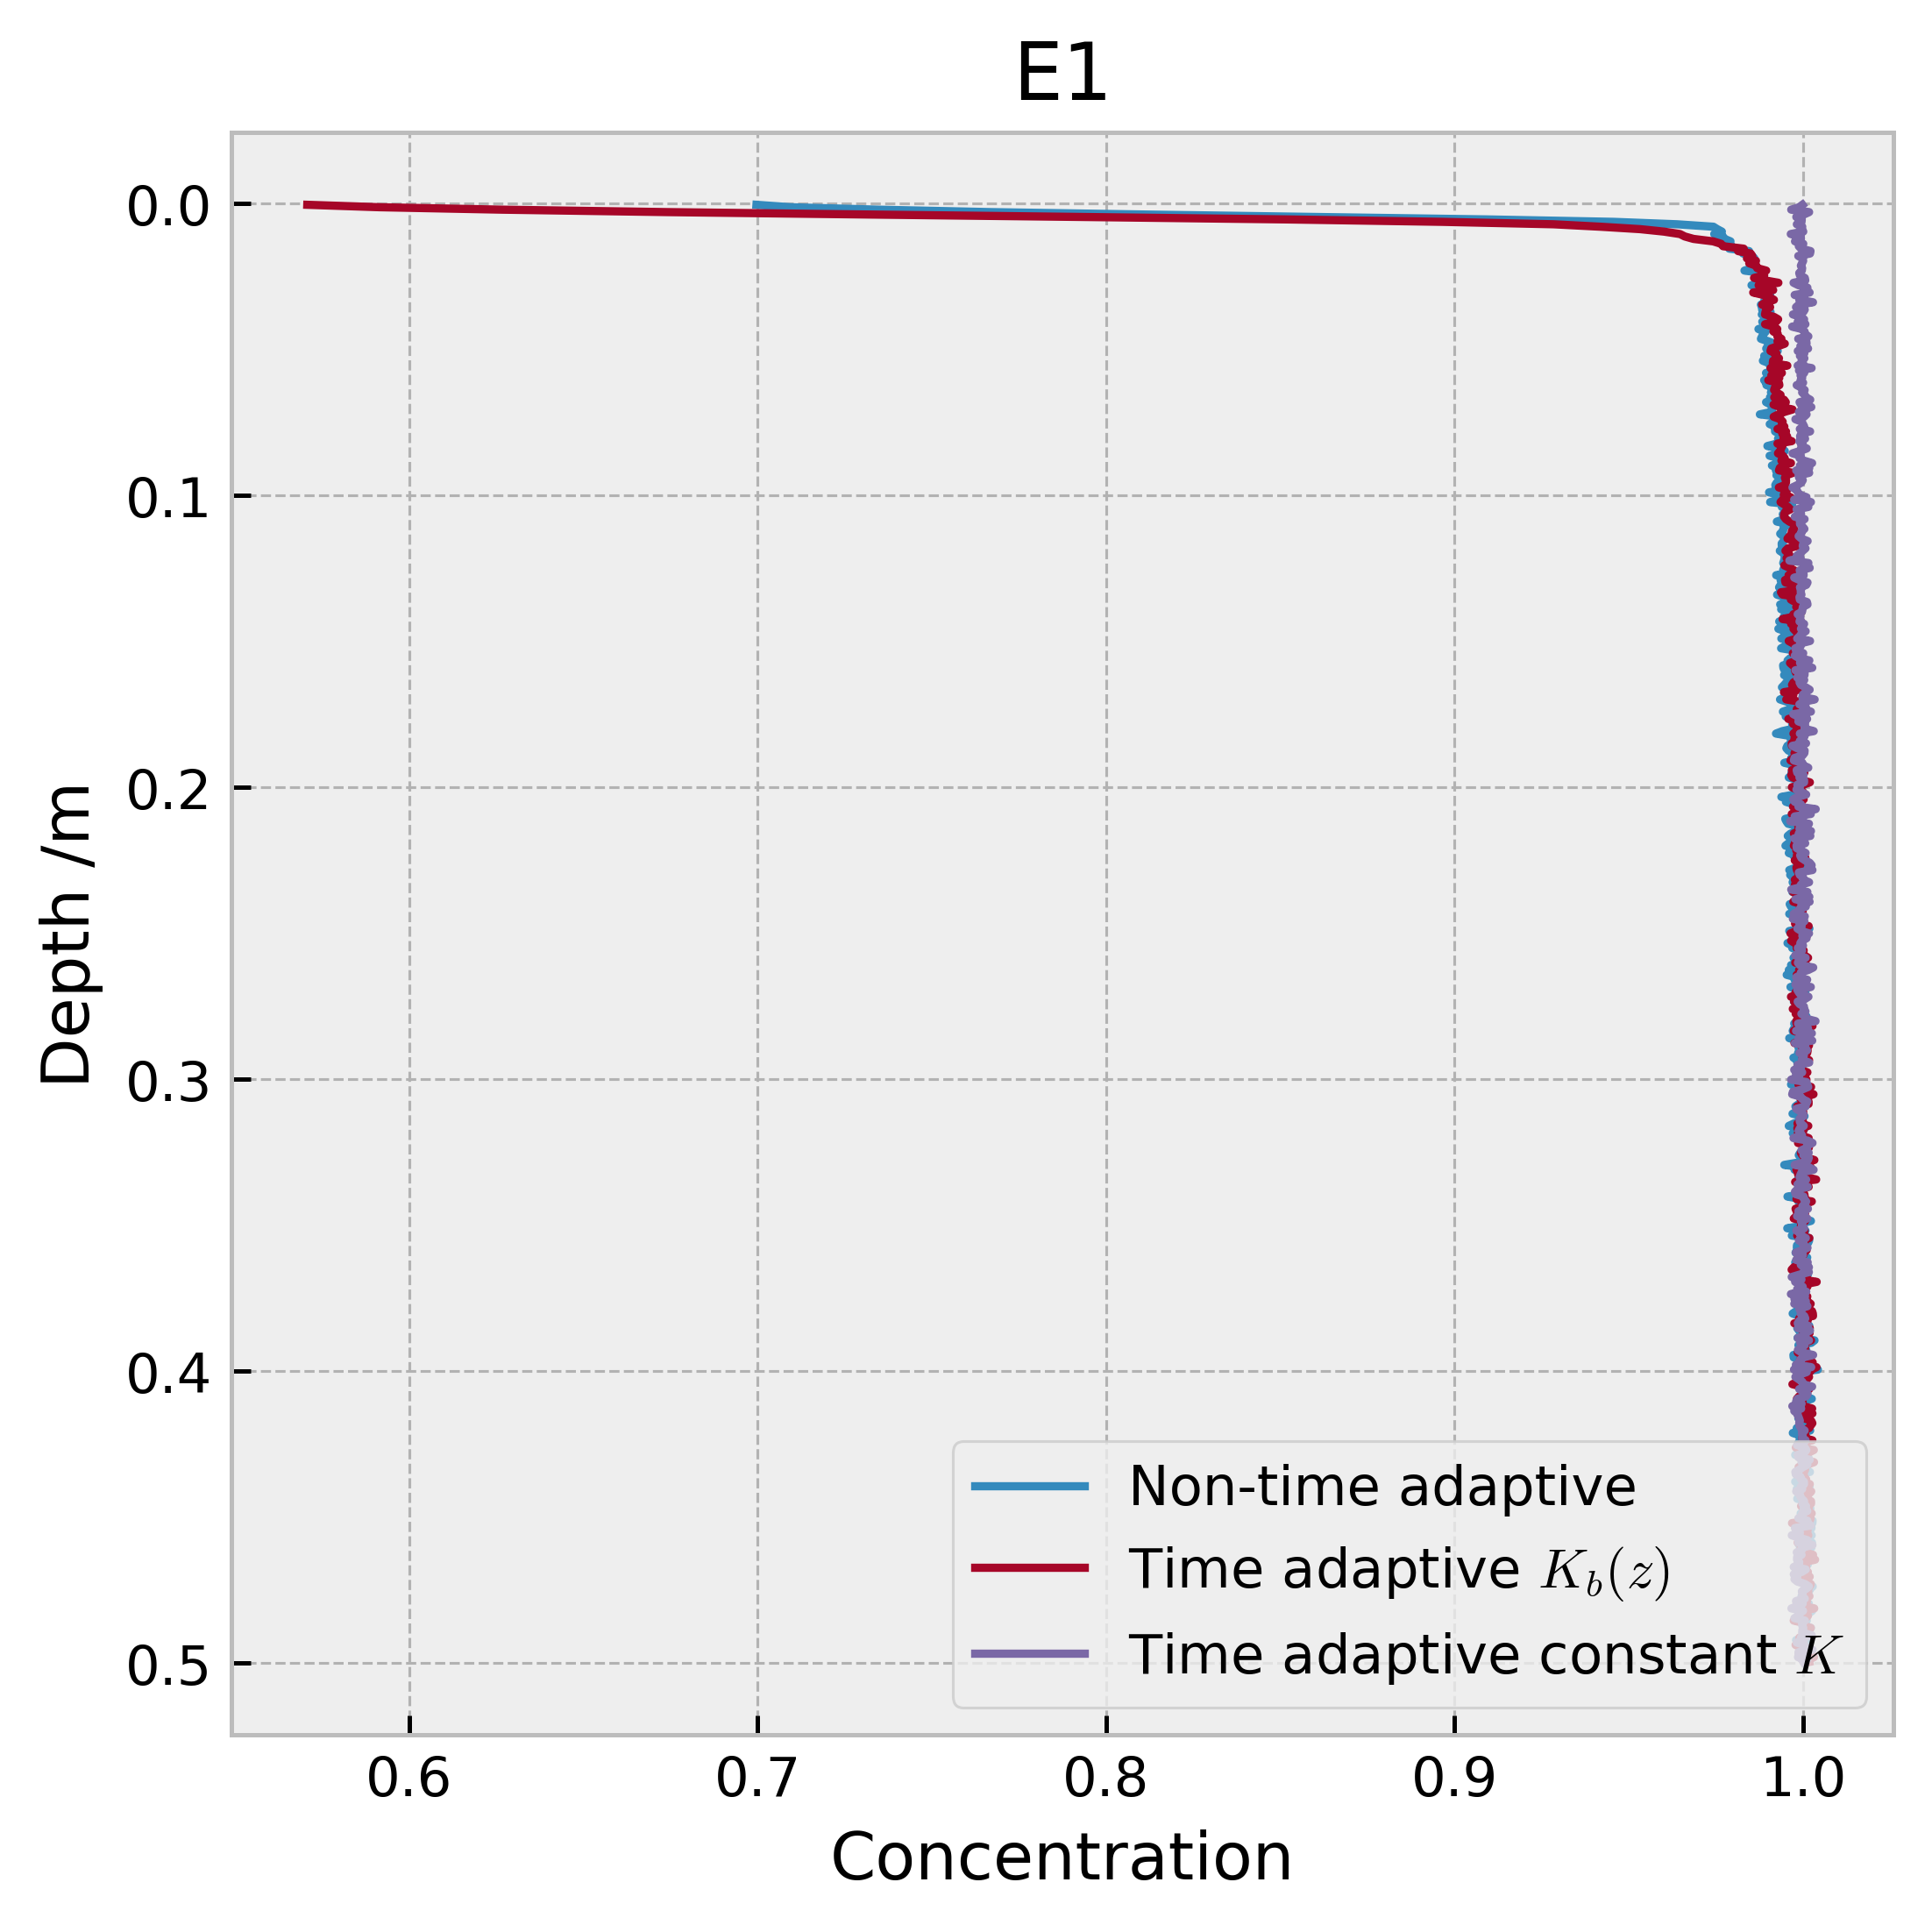

In [7]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, dpi = 450)
ax.plot(E1_normal, midpoints, linewidth=1.5, label="Non-time adaptive")
ax.plot(E1, midpoints, linewidth=1.5, label="Time adaptive $K_b(z)$")
ax.plot(E1_Const, midpoints, linewidth=1.5, label="Time adaptive constant $K$")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.set_title('E1')
ax.invert_yaxis()
#ax.set_xlim(0.6, 1.4)
ax.legend(loc = 4)
plt.tight_layout()

In [41]:
Np = 80000
Nbins = 600
Tmax = 4 * 3600  #Maximum time
dt = 1  #Delta time
H = 2
prosent = 0.1
n = 10
Testdepth = 0.5
NumberOfThread = 4

E1 = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, n, Testdepth, Np,
                   Nbins, step_e)
E1_Const = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, n, Testdepth,
                         Np, Nbins, step_e_const)
n = 1
E1_normal = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, n, Testdepth,
                          Np, Nbins, step_e)

Total number of process:  4
Total number of process:  4
Total number of process:  4


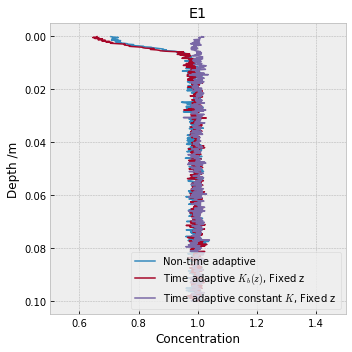

In [8]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True)
ax.plot(E1_normal, midpoints, linewidth=1.5, label="Non-time adaptive")
ax.plot(E1, midpoints, linewidth=1.5, label="Time adaptive $K_b(z)$, Fixed z")
ax.plot(E1_Const, midpoints, linewidth=1.5, label="Time adaptive constant $K$, Fixed z")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.set_title('E1')
ax.invert_yaxis()
ax.set_xlim(0.5, 1.5)
ax.legend(loc = 4)
plt.tight_layout()